# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve
from scripts.auc_curves_data import auc_curves_data
from scripts.auc_curves_plot import auc_curves_plot

## LECTURA Y LIMPIEZA DEL DATASET

In [3]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

## Transformaciones necesarias al df

In [4]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [5]:
feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]

In [6]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE(random_state=420).fit_resample(feat_train, targ_train)
feat_train.shape

(326, 6)

### ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [7]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---
# Función útil para graficar

In [8]:
def model_setup (model):
    model.fit(feat_train,targ_train)
    scoring = cross_val_score(model, feat_train, targ_train,cv=10, scoring=score_metric)
    print("Cross Validation Score: {:.3f} +/- {:.3f}".format(scoring.mean(),scoring.std()))
    predicted = cross_val_predict(model,feat_train,targ_train,cv=10)
    print(classification_report(targ_train, predicted))
    cm = confusion_matrix(targ_train, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

# Preparación de modelos y scores

In [25]:
modelos = [
    # Perceptron(fit_intercept=False, max_iter=40000),
    # Perceptron(fit_intercept=False, max_iter=40000,penalty="l2",random_state=420,alpha=1e-5,eta0=0.05),
    # LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2),
    # SVC(probability=True,gamma=0.61,C=0.85),
    # RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4),
    # AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=0.2),
    # VotingClassifier(estimators=[('lr', LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2)), ('tree', RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)), ('svc', SVC(probability=True,gamma=0.61,C=0.85))],voting='hard'),
    VotingClassifier(estimators=[('lr', LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2)), ('tree', RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)), ('svc', SVC(probability=True,gamma=0.61,C=0.85))],voting='soft')
]
scores = []
for model in modelos:
    model.fit(feat_train,targ_train)
    scores.append(cross_val_score(model, feat_train, targ_train,cv=15, scoring=score_metric))


In [10]:
scores = pd.DataFrame(np.array(scores).T)
scores.columns = ["Per (BL)","Per_op","LR_op","SVC_op","RF_op","ADA_op","VotHard","VotSoft"]

In [11]:
meaned_scores = [0.657,0.711,0.801,0.877,0.865,0.781,0.871,0.862]

<BarContainer object of 8 artists>

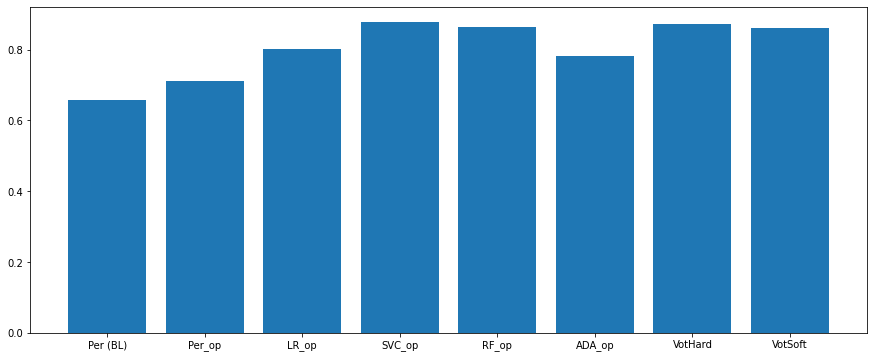

In [12]:
plt.figure(figsize=(15,6))
plt.bar(scores.columns,meaned_scores)

In [13]:
scores

,Per (BL),Per_op,LR_op,SVC_op,RF_op,ADA_op,VotHard,VotSoft
0,0.545455,0.545455,0.636364,0.818182,0.727273,0.727273,0.818182,0.818182
1,0.545455,0.363636,0.727273,0.909091,0.727273,0.909091,0.818182,0.818182
2,0.636364,0.363636,0.727273,0.818182,0.909091,0.636364,0.818182,0.818182
3,0.545455,0.454545,0.909091,0.909091,0.727273,0.727273,0.818182,0.818182
4,0.727273,0.727273,0.818182,0.818182,0.818182,0.636364,0.818182,0.818182
5,0.727273,0.727273,0.818182,0.818182,0.818182,0.727273,0.818182,0.818182
6,0.636364,0.727273,0.818182,0.818182,0.727273,0.727273,0.818182,0.818182
7,0.727273,0.818182,0.909091,0.909091,1.000000,0.909091,1.000000,1.000000
8,0.818182,0.727273,0.818182,0.818182,1.000000,1.000000,0.909091,0.909091
9,0.636364,0.727273,0.818182,1.000000,1.000000,0.818182,1.000000,1.000000


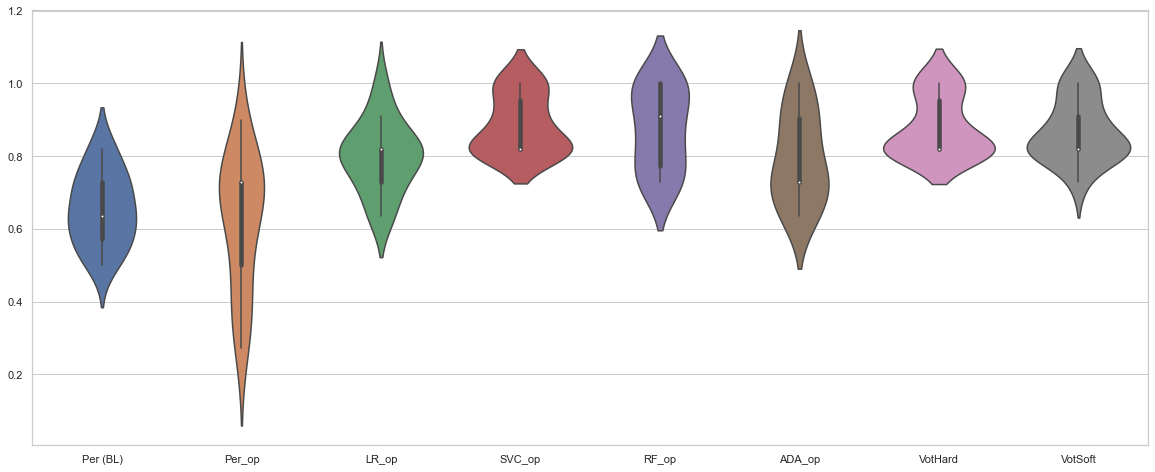

In [14]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,8))
sns.violinplot(data=scores)
plt.show()

---
# Gráficos AOC de ROC y PR

In [23]:
AOC_data = []

for model in modelos:
    try:
        (ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(model,feat_train,targ_train)
        AOC_data.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, model))        
    except:
        print(f"No se pudo analizar este modelo {model} 😅")

No se pudo analizar este modelo VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=2, fit_intercept=False,
                                                 max_iter=40000)),
                             ('tree',
                              RandomForestClassifier(min_impurity_decrease=0.0002,
                                                     n_estimators=400)),
                             ('svc',
                              SVC(C=0.85, gamma=0.61, probability=True))]) 😅


In [20]:
len(AOC_data[0])

5

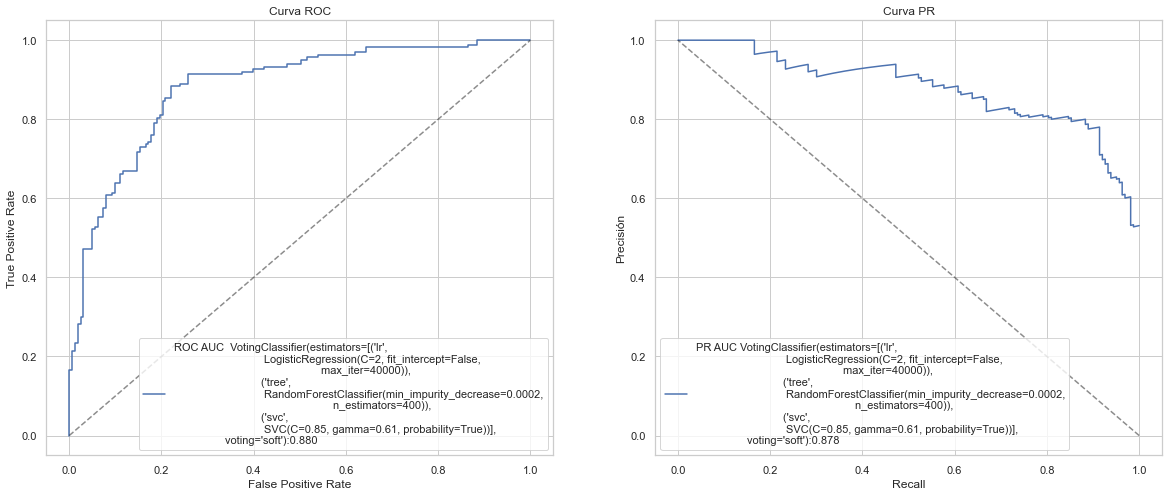

In [24]:
auc_curves_plot(AOC_data)

---
---
---

In [141]:
names = ["Per (BL)","Per_op","LR_op","SVC_op","RF_op","ADA_op","XGBC_op","VotHard","VotSoft","ANN"]
scores_s_time = np.array([0.542,0.773,0.731,0.895,0.872,0.811,0.813,0.865,0.836,0.954],dtype="float32")
scores_c_time = np.array([0.721,0.731,0.811,0.916,0.917,0.837,0.905,0.916,0.910,0.984],dtype="float32")
scores_test = np.array([0.538,0.400,0.667,0.586,0.667,0.526,0.579,0.652,0.619,0.647],dtype="float32")
ss = np.array([scores_s_time,scores_c_time,scores_test]).T


In [140]:
ss

array([[0.542, 0.721, 0.538],
       [0.773, 0.731, 0.4  ],
       [0.731, 0.811, 0.667],
       [0.895, 0.916, 0.586],
       [0.872, 0.917, 0.667],
       [0.811, 0.837, 0.526],
       [0.813, 0.905, 0.579],
       [0.865, 0.916, 0.652],
       [0.836, 0.91 , 0.619],
       [0.954, 0.984, 0.647]], dtype=float32)

In [142]:
ss.shape

(10, 3)

In [184]:
scorings = pd.DataFrame(ss,columns=["s/time","c/time","test"])
scorings["algoritmo"] = names
scorings = scorings.set_index("algoritmo")

In [185]:
scorings

,s/time,c/time,test
algoritmo,,,
Per (BL),0.542,0.721,0.538
Per_op,0.773,0.731,0.400
LR_op,0.731,0.811,0.667
SVC_op,0.895,0.916,0.586
RF_op,0.872,0.917,0.667
ADA_op,0.811,0.837,0.526
XGBC_op,0.813,0.905,0.579
VotHard,0.865,0.916,0.652
VotSoft,0.836,0.910,0.619


<AxesSubplot:title={'center':'Scorings'}, xlabel='Algoritmos', ylabel='Recall'>

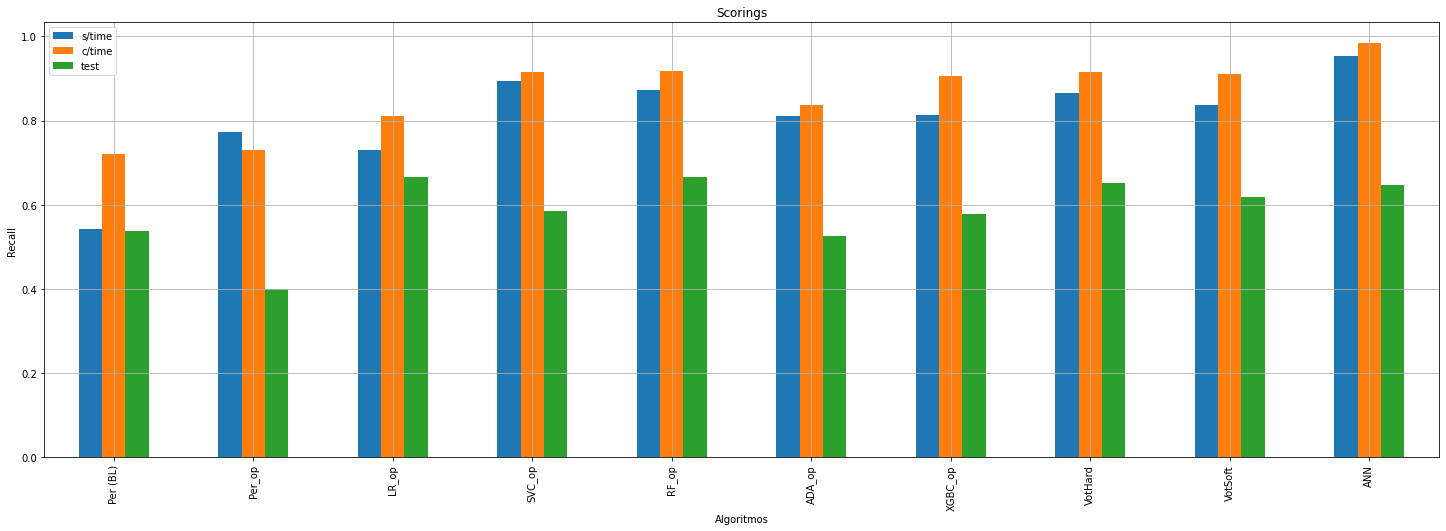

In [186]:
scorings.plot(kind="bar",figsize=(25,8),title="Scorings",ylabel="Recall",xlabel="Algoritmos",grid=True)

In [138]:
scorings = scorings.melt("algoritmo",("s","c","test"))
scorings.astype({"value":float})

,algoritmo,variable,value
0,Per (BL),s,0.542
1,Per_op,s,0.773
2,LR_op,s,0.731
3,SVC_op,s,0.895
4,RF_op,s,0.872
5,ADA_op,s,0.811
6,XGBC_op,s,0.813
7,VotHard,s,0.865
8,VotSoft,s,0.836
9,ANN,s,0.954


In [108]:
scorings.head()

,algoritmo,variable,value
0,Per (BL),s,0.542
1,Per_op,s,0.773
2,LR_op,s,0.731
3,SVC_op,s,0.895
4,RF_op,s,0.872


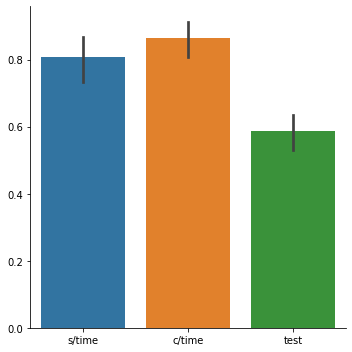

In [152]:
sns.catplot(data=scorings,kind="bar",hue=)